# 1.	Необходимо скачать и подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples/notebooks для обучения модели на сегментацию губ (обратите внимание, что сегментация подразумевает уже два класса: фон и губы).

### Libs

In [1]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from PIL import Image

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from torch.autograd import set_detect_anomaly

### Base vars

In [2]:
ROOT_DIR = '../data/set-lipstick-original'

LR = 0.001
EPOCHS = 5

PACK = 400 # число объектов в тренировочном датасете

### View data info

In [3]:
# describe
df = pd.read_csv(ROOT_DIR + '/list.csv')
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [4]:
# get class name
class_name = df['class'].unique()[0]
class_name

'Lips'

### Processing data

In [5]:
def createDataframe(direction: str, name: str) -> pd.DataFrame:

    df = pd.DataFrame({name: os.listdir(direction)}) # create dataframe

    df[name] = direction + df[name] # create file address
    df['index'] = [i[-12:-4] for i in df[name]] # create file index
    df['index'] = df['index'].astype('int16') # retyde index in int 16
    
    df.sort_values(by='index') # sorted by index
    
    return df

In [6]:
imgsDF = createDataframe(direction=ROOT_DIR + '/720p/', name='image')
print(imgsDF.tail())

masksDF = createDataframe(direction=ROOT_DIR + '/mask/', name='mask')
print(masksDF.tail())

                                                   image  index
28589  ../data/set-lipstick-original/720p/image000285...  28590
28590  ../data/set-lipstick-original/720p/image000285...  28591
28591  ../data/set-lipstick-original/720p/image000285...  28592
28592  ../data/set-lipstick-original/720p/image000285...  28593
28593  ../data/set-lipstick-original/720p/image000285...  28594
                                                    mask  index
28535  ../data/set-lipstick-original/mask/mask0002859...  28590
28536  ../data/set-lipstick-original/mask/mask0002859...  28591
28537  ../data/set-lipstick-original/mask/mask0002859...  28592
28538  ../data/set-lipstick-original/mask/mask0002859...  28593
28539  ../data/set-lipstick-original/mask/mask0002859...  28594


- Часть масок утеряна
- Нужно оставить те файлы в финальном датафрейме, маски которых есть

In [7]:
df = imgsDF.merge(masksDF, on='index', how='inner') # merge by matches in indices
df = df[['image', 'mask']]
df.tail()

,image,mask
28535,../data/set-lipstick-original/720p/image000285...,../data/set-lipstick-original/mask/mask0002859...
28536,../data/set-lipstick-original/720p/image000285...,../data/set-lipstick-original/mask/mask0002859...
28537,../data/set-lipstick-original/720p/image000285...,../data/set-lipstick-original/mask/mask0002859...
28538,../data/set-lipstick-original/720p/image000285...,../data/set-lipstick-original/mask/mask0002859...
28539,../data/set-lipstick-original/720p/image000285...,../data/set-lipstick-original/mask/mask0002859...


255 1.0


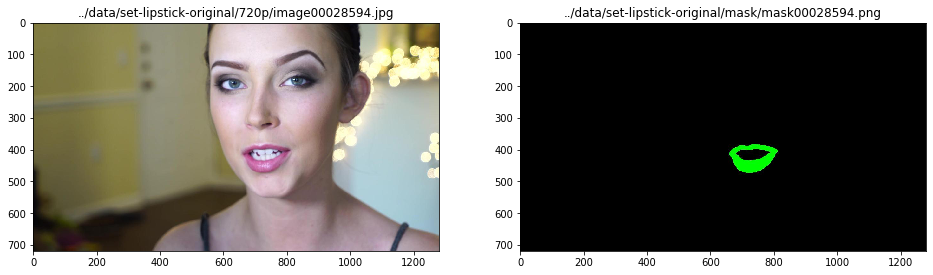

In [8]:
# imgs in array to view
idx = 28539

imgArray = plt.imread(df.loc[idx]['image'])
maskArray = plt.imread(df.loc[idx]['mask'])

print(imgArray.max(), maskArray.max()) # view RGB value

# view
plt.figure(figsize=(16, 16))

plt.subplot(1, 2, 1)
plt.imshow(imgArray) # image***.jpg
plt.title(df.loc[idx]['image'])

plt.subplot(1, 2, 2)
plt.imshow(maskArray) # mask***.png
plt.title(df.loc[idx]['mask'])

plt.show()

In [9]:
class CustomDataset(Dataset):
    
    def __init__(self, df):
        
        self.imgSeries = df.iloc[:, 0] # image
        self.lblSeries = df.iloc[:, 1] # mask
        self.count_pair = df.shape[0]  # count image-mask
        
    def __getitem__(self, index):
        
        img_open = Image.open(self.imgSeries[index])
        img_256x256 = img_open.resize((256, 256))
        imgArray = np.asarray(img_256x256).astype('float')
        imgTensor = torch.as_tensor(imgArray) / 255 # torch.Size([256, 256, 3])
        imgTensor = imgTensor.permute(2,0,1)        # torch.Size([3, 256, 256])
        
        lblArray = plt.imread(self.lblSeries[index])[:, :, 1]          # (720, 1280)
        lblTensor = torch.as_tensor(lblArray).unsqueeze(0)             # torch.Size([1, 720, 1280])
        lblTensor = lblTensor.unsqueeze(0)                             # torch.Size([1, 1, 720, 1280])
        lblTensor = F.interpolate(lblTensor, size=256, mode='nearest') # torch.Size([1, 1, 256, 256])
        lblTensor = lblTensor.squeeze(0).squeeze(0)                    # torch.Size([256, 256])
        
        return imgTensor.float(), lblTensor.float()
    
    def __len__(self):
        
        return self.count_pair

In [10]:
X_train, X_test = train_test_split(df, test_size=0.3, shuffle=True)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

train_dataCustomDataset = CustomDataset(X_train[:PACK])
test_dataCustomDataset = CustomDataset(X_test)

trainDataLoader = DataLoader(train_dataCustomDataset, batch_size=8, shuffle=True)
testDataLoader = DataLoader(test_dataCustomDataset, batch_size=4, shuffle=False)

### View data

torch.Size([8, 3, 256, 256]) tensor(1.)
torch.Size([8, 256, 256]) tensor(1.)


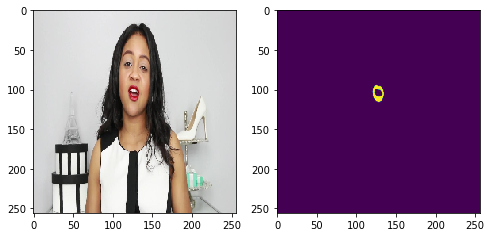

In [11]:
"""train"""
plt.figure(figsize=(8,8))
for img, lbl in trainDataLoader:
    
    print(img.shape, img.max()) 
    print(lbl.shape, lbl.max())
    
    plt.subplot(1,2,1)
    plt.imshow(img[0].permute(1,2,0))
    
    plt.subplot(1,2,2)
    plt.imshow(lbl[0])
    
    plt.show()
    break

torch.Size([4, 3, 256, 256]) tensor(1.)
torch.Size([4, 256, 256]) tensor(1.)


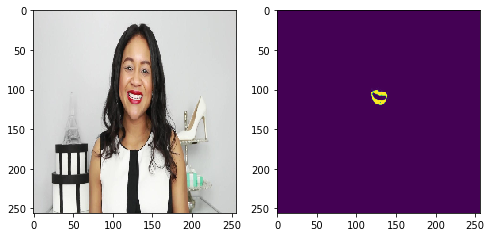

In [12]:
"""test"""
plt.figure(figsize=(8,8))
for img, lbl in testDataLoader:
    print(img.shape, img.max()) 
    print(lbl.shape, lbl.max())
    plt.subplot(1,2,1)
    plt.imshow(img[0].permute(1,2,0))
    plt.subplot(1,2,2)
    plt.imshow(lbl[0])
    plt.show()
    break

# 2. И затем обучить Модель на выбор из segmentation_models_pytorch

In [13]:
class SoftDiceLoss(nn.Module):
    
    def __init__(self, weight=None, size_average=True):
        super(SoftDiceLoss, self).__init__()
        
    def forward(self, probs, targets):
        
        smooth = 1
        num = targets.size(0)
        m1 = probs.view(num, -1)
        m2 = targets.view(num, -1)
        intersection = (m1 * m2)
        
        score = (2. * intersection.sum(1) + smooth) / (m1.sum(1) + m2.sum(1) + smooth)
        print(score.sum())
        score = 1 - score.sum() / num
        
        return score
    
    def backward(self, grad_output):
        
        input, target = self.saved_variables
        grad_input = grad_target = None
        
        if self.needs_input_grad[0]:
            grad_input = grad_output * 2 * (target + self.union - self.inter) / self.union**2
        if self.needs_input_grad[1]:
            grad_target = None
            
        return grad_input, grad_target

In [14]:
class UNet(nn.Module):

    def __init__(self, num_classes):
        super(UNet, self).__init__()

        # Левая сторона (Путь уменьшения размерности картинки)
        self.down_conv_11 = self.conv_block(in_channels=3, out_channels=64)
        self.down_conv_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_21 = self.conv_block(in_channels=64, out_channels=128)
        self.down_conv_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_31 = self.conv_block(in_channels=128, out_channels=256)
        self.down_conv_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_41 = self.conv_block(in_channels=256, out_channels=512)
        self.down_conv_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        
        # Правая сторона (Путь увеличения размерности картинки)
        self.up_conv_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.up_conv_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_22 = self.conv_block(in_channels=512, out_channels=256)
        self.up_conv_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_32 = self.conv_block(in_channels=256, out_channels=128)
        self.up_conv_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.up_conv_42 = self.conv_block(in_channels=128, out_channels=64)
        
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        self.softmax = nn.Softmax()
    
    @staticmethod
    def conv_block(in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    @staticmethod
    def crop_tensor(target_tensor, tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2

        return tensor[:,:, delta:tensor_size-delta, delta:tensor_size-delta]


    def forward(self, X):
        # Проход по левой стороне
        x1 = self.down_conv_11(X) # [-1, 64, 256, 256]
        x2 = self.down_conv_12(x1) # [-1, 64, 128, 128]
        x3 = self.down_conv_21(x2) # [-1, 128, 128, 128]
        x4 = self.down_conv_22(x3) # [-1, 128, 64, 64]
        x5 = self.down_conv_31(x4) # [-1, 256, 64, 64]
        x6 = self.down_conv_32(x5) # [-1, 256, 32, 32]
        x7 = self.down_conv_41(x6) # [-1, 512, 32, 32]
        x8 = self.down_conv_42(x7) # [-1, 512, 16, 16]
        
        middle_out = self.middle(x8) # [-1, 1024, 16, 16]

        # Проход по правой стороне
        x = self.up_conv_11(middle_out) # [-1, 512, 32, 32]
        y = self.crop_tensor(x, x7)
        x = self.up_conv_12(torch.cat((x, y), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        
        x = self.up_conv_21(x) # [-1, 256, 64, 64]
        y = self.crop_tensor(x, x5)
        x = self.up_conv_22(torch.cat((x, y), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        
        x = self.up_conv_31(x) # [-1, 128, 128, 128]
        y = self.crop_tensor(x, x3)
        x = self.up_conv_32(torch.cat((x, y), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        
        x = self.up_conv_41(x) # [-1, 64, 256, 256]
        y = self.crop_tensor(x, x1)
        x = self.up_conv_42(torch.cat((x, y), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        
        output = self.output(x) # [-1, num_classes, 256, 256]
        output = self.softmax(output)

        return output

In [15]:
total_steps = len(trainDataLoader)
print(f'{EPOCHS} epochs, {total_steps} total_steps per epoch')

5 epochs, 50 total_steps per epoch


In [16]:
modelUnet = UNet(num_classes=1) # model init
optimizer = torch.optim.Adam(modelUnet.parameters())
# criterion = SoftDiceLoss()

In [17]:
def dice_loss(output, target, weights=None, ignore_index=None):

    eps = 0.0001

    output = output.float().exp()
    target = target.type(torch.int64)
    encoded_target = output.detach() * 0
    
    if ignore_index is not None:
        mask = target == ignore_index
        target = target.clone()
        target[mask] = 0
        encoded_target.scatter_(1, target.unsqueeze(1), 1)
        mask = mask.unsqueeze(1).expand_as(encoded_target)
        encoded_target[mask] = 0
    else:
        encoded_target.scatter_(0, target.unsqueeze(1), 1)

    if weights is None:
        weights = 1

    intersection = output * encoded_target
    numerator = 2 * intersection.sum(0).sum(1).sum(1)
    denominator = output + encoded_target

    if ignore_index is not None:
        denominator[mask] = 0
    denominator = denominator.sum(0).sum(1).sum(1) + eps
    loss_per_channel = weights * (1 - (numerator / denominator))

    return loss_per_channel.sum() / output.size(1)

In [18]:
#Импортируем библиотеку time для расчета, сколько времени у нас уходит на одну эпоху
import time
from torch.autograd import Variable

# Полезная функция для детектирования аномалий в процессе обучения
torch.autograd.set_detect_anomaly(True)

# запускаем главный тренировочный цикл
epoch_losses = []
for epoch in range(EPOCHS):
    time1 = time.time()
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(trainDataLoader):

        optimizer.zero_grad()
        
        outputs = modelUnet(data)
        
        loss = dice_loss(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss.append(loss.item())
        
        if batch_idx%10==0:
            print(f'batch index : {batch_idx} | loss : {loss.item()}')

    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    time2 = time.time()
    print(f'Spend time for 1 epoch: {time2-time1} sec')
    
    epoch_losses.append(epoch_loss)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


batch index : 0 | loss : 0.7569563984870911
batch index : 10 | loss : 0.7494790554046631
batch index : 20 | loss : 0.7561906576156616
batch index : 30 | loss : 0.7584885954856873
batch index : 40 | loss : 0.7570782899856567
Epoch 1, loss:  0.7553499209880828
Spend time for 1 epoch: 1496.481350183487 sec
batch index : 0 | loss : 0.7587951421737671
batch index : 10 | loss : 0.7568589448928833
batch index : 20 | loss : 0.7569912075996399
batch index : 30 | loss : 0.7531298398971558
batch index : 40 | loss : 0.7467763423919678
Epoch 2, loss:  0.755150500535965
Spend time for 1 epoch: 1420.1343195438385 sec
batch index : 0 | loss : 0.7569354772567749
batch index : 10 | loss : 0.7589380145072937
batch index : 20 | loss : 0.7572593092918396
batch index : 30 | loss : 0.747126579284668
batch index : 40 | loss : 0.7575100064277649
Epoch 3, loss:  0.7553356277942658
Spend time for 1 epoch: 1422.4796822071075 sec
batch index : 0 | loss : 0.749444305896759
batch index : 10 | loss : 0.75973939895629

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


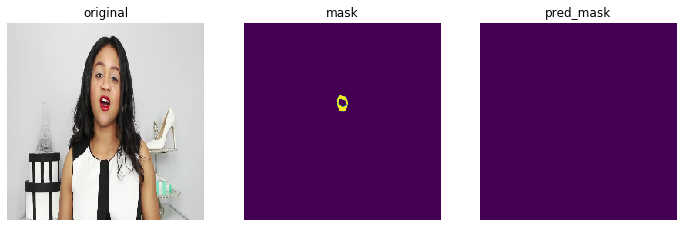

In [19]:
idx = 1

plt.figure(figsize=(12, 12))
for imgs, lbls in testDataLoader:
    
    outputs = modelUnet(img)
    
    plt.subplot(1, 3, 1)
    plt.imshow(imgs[idx].permute(1,2,0))
    plt.title('original')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(lbls[idx])
    plt.title('mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(outputs[idx, 0].detach())
    plt.title('pred_mask')
    plt.axis('off')
    
    break

#### Вывод:
Маска губ не вопроизвелась. алзможно проблема в модели.

# 3. *(Усложненное задание) Переделайте архитектуру декодера Unet так, как в этой работе https://www.ics.uci.edu/~haoyum3/papers/slides_icivc.pdf. Эта тема пересекается с темой о второго вебинара о LSTM-сетях. И попробуйте обучить получившуюся нейронную сеть.